## Constructing and training of the VAE
#### In this notebook the neural network will be constructed and using the decoder of it, the requested dataset will be generated.

#### Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
from tensorflow.keras.losses import mse, BinaryCrossentropy
from tensorflow.keras import backend as K

from convertors import momentums_to_angles

/Users/ilias/.pyenv/versions/running_tensorflow/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


#### Notebook environment setup

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_columns = 15
np.random.seed(111)
tf.random.set_seed(111)

#### Provide sampling layer for the VAE

In [4]:
def sample(args):
    """ Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#### Import the dataset with no smearing, to train the network.

In [5]:
df = pd.read_csv('Data/monte_carlo_dataset.csv')

dataset = df.to_numpy()[:, 1:]
dataset.shape

(100000, 10)

#### Getting dimensions of the dataset. Will serve as parameters to our network

In [6]:
num_of_samples = dataset.shape[0]
input_shape = dataset.shape[1]

#### Setting properties for the VAE

In [7]:
E_tot = 400
activation_encoder_hidden = 'relu'
size_latent = 4

#### Initialise scaler for (de)normalisation

In [8]:
scaler = MinMaxScaler()
scaler.fit(dataset)

MinMaxScaler()

#### Defining functions for normalisation & denormalisation

In [9]:
def normalise(data):
    return scaler.transform(data)

def denormalise(data):
    return scaler.inverse_transform(data)

## Constructing the Variational Auto-Encoder(VAE)
#### Define the encoder and the decoder

In [10]:
encoder_input = Input(shape=input_shape, name="encoder_input")
encoder_hidden = Dense(7, activation=activation_encoder_hidden, name="encoder_hidden")(encoder_input)
z_mean = Dense(size_latent, activation='linear', name="mean")(encoder_hidden)
z_log_var = Dense(size_latent, activation='linear', name="logvariance")(encoder_hidden)
z = Lambda(sample, output_shape=(size_latent,), name="z")([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

decoder_input = Input(shape=(size_latent,), name="decoder_input")
decoder_hidden = Dense(7, activation=activation_encoder_hidden, name="decoder_hidden")(decoder_input)
decoder_output = Dense(input_shape, activation="linear", name="decoder_outputs")(decoder_hidden)

decoder = Model(decoder_input, decoder_output, name="decoder")

outputs = decoder(encoder(encoder_input)[2])

Metal device set to: Apple M1


2022-08-05 16:39:01.974970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 16:39:01.975051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Checks if there is already a trained model. If not, it creates one.

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 encoder (Functional)        [(None, 4),               141       
                              (None, 4),                         
                              (None, 4)]                         
                                                                 
 decoder (Functional)        (None, 10)                115       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


2022-08-05 16:39:02.139971: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-05 16:39:02.339275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 18s 6ms/step - loss: 0.0795


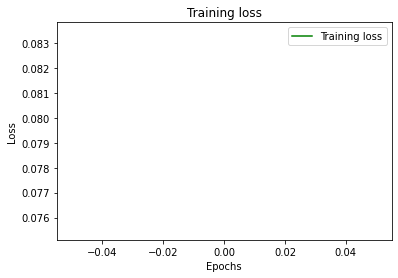

In [11]:
if not os.path.exists('./Model/vae.hdf5'):
    vae = Model(encoder_input, outputs, name="vae")
    vae.summary()

    # Calculate loss
    reconstruction_loss = mse(encoder_input, outputs)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    vae.save('./Model/vae.hdf5', save_format='tf')
else:
    vae = load_model('./Model/vae.hdf5')

#### Plotting the distribution of each dimension for the latent space of the VAE

[-5.0, 5.0, 0.0, 45000.0]

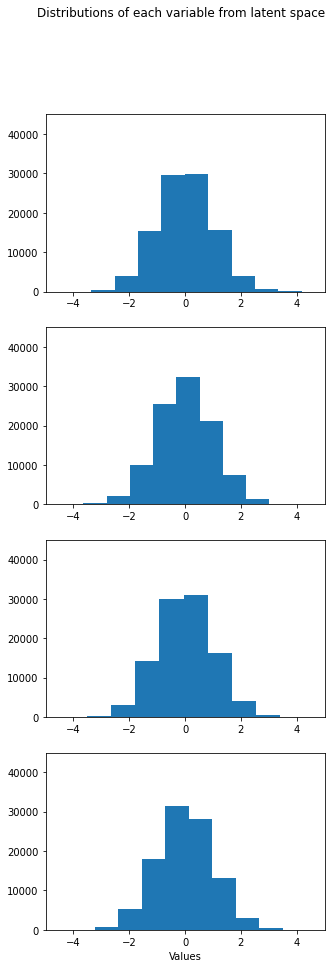

In [12]:
latent_space = encoder(normalise(dataset))[2].numpy()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(5, 15)
fig.suptitle('Distributions of each variable from latent space')

ax1.hist(latent_space[:, 0])
ax2.hist(latent_space[:, 1])
ax3.hist(latent_space[:, 2])
ax4.hist(latent_space[:, 3])
ax4.set_xlabel('Values')

plt.setp(ax1, xlim=[-5, 5], ylim=[0, 45000])
plt.setp(ax2, xlim=[-5, 5], ylim=[0, 45000])
plt.setp(ax3, xlim=[-5, 5], ylim=[0, 45000])
plt.setp(ax4, xlim=[-5, 5], ylim=[0, 45000])

#### Print the means and standard deviations for each of the latent variables

In [13]:
print('Latent dimension 1: ', np.mean(latent_space[:, 0]), np.std(latent_space[:, 0]))
print('Latent dimension 2: ', np.mean(latent_space[:, 1]), np.std(latent_space[:, 1]))
print('Latent dimension 3: ', np.mean(latent_space[:, 2]), np.std(latent_space[:, 2]))
print('Latent dimension 4: ', np.mean(latent_space[:, 3]), np.std(latent_space[:, 3]))

Latent dimension 1:  0.001152516 1.0001465
Latent dimension 2:  0.0001686531 0.99561596
Latent dimension 3:  0.0035315997 0.9985281
Latent dimension 4:  0.002831469 1.0005176


#### Generate data

In [14]:
def generate(n_samples):
    nn_input = tf.reshape(tf.stack([tf.reshape(tf.stack([tf.random.normal([1, 1], mean=np.mean(latent_space[:, i]), stddev=np.std(latent_space[:, i])) for i in range(size_latent)]), [1, size_latent]) for _ in tqdm(range(n_samples))]), [n_samples, size_latent])
    si = denormalise(decoder(nn_input).numpy())

    return si

In [15]:
generated_data = generate(100000)

100%|██████████| 100000/100000 [10:18<00:00, 161.78it/s]


In [16]:
generated_data.shape

(100000, 10)

#### Create final dataset & export to csv

In [17]:
final_df = pd.DataFrame(generated_data, columns=['E1', 'p_x1', 'p_y1', 'p_z1', 'm1',
                                                 'E2', 'p_x2', 'p_y2', 'p_z2', 'm2'])

In [18]:
final_df['E1'] = np.abs(final_df['E1'].to_numpy())
final_df['E2'] = np.abs(final_df['E2'].to_numpy())
final_df['m1'] = np.abs(final_df['m1'].to_numpy())
final_df['m2'] = np.abs(final_df['m2'].to_numpy())

In [19]:
final_df.insert(0, 'event_id', range(1, 1 + len(final_df)))

final_df.to_csv('Data/vae_dataset.csv', index=False)

print('A sample of our dataset:')
final_df.head(10)

A sample of our dataset:


event_id          E1      p_x1       p_y1        p_z1         m1  \
0         1  200.297409  2.323284  -1.079818  126.413826  56.856457   
1         2  198.949081 -3.074366  -1.016148  124.713875  55.859615   
2         3  194.681412 -4.102768 -12.714890  122.851364  53.563118   
3         4  199.904114  0.748904  -1.061257  125.917984  56.565701   
4         5  200.124344  1.180735   0.495372  126.939911  57.065891   
5         6  199.232224 -3.098196  -0.468962  124.828407  55.984589   
6         7  199.159821  2.884386  -3.046904  125.926910  56.211941   
7         8  200.423386 -1.756323   3.466937  125.429962  56.693798   
8         9  199.266510 -1.803549  -1.031148  125.114113  56.094307   
9        10  199.312027 -7.996486   2.531201  124.712563  56.153431   

           E2      p_x2      p_y2        p_z2         m2  
0  200.848694  3.505972  1.604423 -124.350685  57.238571  
1  199.522110  1.285695 -2.208735 -125.282494  56.199589  
2  194.645905 -4.496546 -8.333392 -121.340263  53.695217  
3  200.461761  2.858371  0.492217 -124.622475  56.935520  
4  200.828461  0.999648  1.706268 -124.578644  57.271629  
5  199.695694  1.907471 -1.141463 -125.734665  56.269749  
6  199.235352  0.245113  1.112759 -124.487366  56.772987  
7  198.980804  1.934102  1.459007 -125.289856  56.962086  
8  199.834442  1.808423 -1.310972 -125.063118  56.444206  
9  198.775711  1.375139 -1.300504 -125.468681  55.794266

### Plot histograms for energy and azimuthal angle (φ) between VAE generated dataset and Monte Carlo generated dataset
##### Import Monte Carlo dataset

In [20]:
monte_carlo_df = pd.read_csv('Data/monte_carlo_dataset.csv')

#### Plot energy histograms

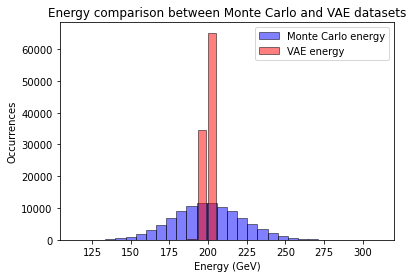

In [21]:
range_min = min([np.min(monte_carlo_df['E1'].to_numpy()), np.min(final_df['E1'].to_numpy())])
range_max = max([np.max(monte_carlo_df['E1'].to_numpy()), np.max(final_df['E1'].to_numpy())])

plt.hist(monte_carlo_df['E1'], range=[range_min, range_max], bins=30, edgecolor='black', color='blue', rwidth=1, alpha=0.5)
plt.hist(final_df['E1'], range=[range_min, range_max], bins=30, edgecolor='black', color='red', rwidth=0.8, alpha=0.5)
plt.title('Energy comparison between Monte Carlo and VAE datasets')
plt.xlabel('Energy (GeV)')
plt.ylabel('Occurrences')
plt.legend(['Monte Carlo energy', 'VAE energy'], loc=1)

#### Plot azimuthal angle histograms

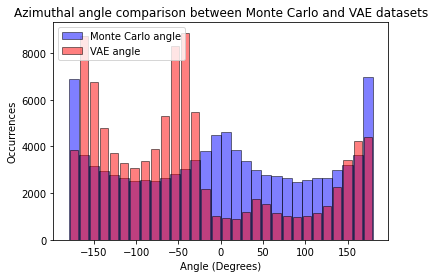

In [22]:
phis_mc, _, _ = momentums_to_angles(monte_carlo_df['p_x1'].to_numpy(), monte_carlo_df['p_y1'].to_numpy(), monte_carlo_df['p_z1'].to_numpy())
phis_vae, _, _ = momentums_to_angles(final_df['p_x1'].to_numpy(), final_df['p_y1'].to_numpy(), final_df['p_z1'].to_numpy())

phis_mc = np.rad2deg(phis_mc)
phis_vae = np.rad2deg(phis_vae)

range_min = min([np.min(phis_mc), np.min(phis_vae)])
range_max = max([np.max(phis_mc), np.max(phis_vae)])

plt.hist(phis_mc, bins=30, range=[range_min, range_max], edgecolor='black', color='blue', alpha=0.5, rwidth=1)
plt.hist(phis_vae, bins=30, range=[range_min, range_max], edgecolor='black', color='red', alpha=0.5, rwidth=0.8)
plt.title('Azimuthal angle comparison between Monte Carlo and VAE datasets')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Occurrences')
plt.legend(['Monte Carlo angle', 'VAE angle'], loc=2)

### Plot the relativistic dispersion relation

Text(0, 0.5, 'Momentum (GeV/c)')

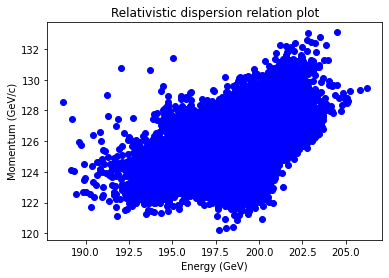

In [23]:
final_df['total_momentum'] = np.sqrt(np.square(final_df['p_x1']) + np.square(final_df['p_y1']) + np.square(final_df['p_z1']))

plt.scatter(final_df['E1'], final_df['total_momentum'], c='blue')
plt.title('Relativistic dispersion relation plot')
plt.xlabel('Energy (GeV)')
plt.ylabel('Momentum (GeV/c)')

### Fit the points in a linear regression model and calculate Mean Square Error as a figure of merit


/Users/ilias/.pyenv/versions/running_tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'Momentum (GeV/c)')

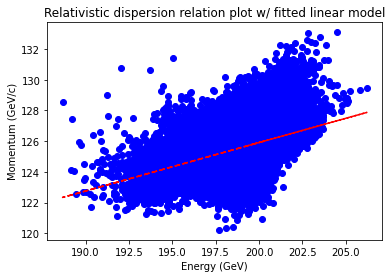

In [24]:
poly1d_fn = np.poly1d(np.polyfit(final_df['E1'], final_df['total_momentum'], 1))

plt.plot(final_df['E1'], final_df['total_momentum'], 'bo', final_df['E1'], poly1d_fn(final_df['E1']), '--r')
plt.title('Relativistic dispersion relation plot w/ fitted linear model')
plt.xlabel('Energy (GeV)')
plt.ylabel('Momentum (GeV/c)')

In [25]:
print(poly1d_fn)

 
0.3154 x + 62.84


In [26]:
a = poly1d_fn[1]
b = 1
c = poly1d_fn[0]

In [27]:
def shortest_distance(xs, ys, a, b, c):
    d = np.abs((a * xs + b * ys + c)) / (np.sqrt(a * a + b * b))
    return d

In [28]:
def rmse(data):
    return np.sqrt(np.sum(np.divide(np.power(data, 2), data.shape[0])))

In [29]:
ds = shortest_distance(final_df['E1'].to_numpy(), final_df['total_momentum'].to_numpy(), a, b, c)
print('Root Mean Squared Error is: ', rmse(ds))

Root Mean Squared Error is:  239.71949546276346
